## Linear Regression and Other Things: Cross-sectional, Panel, DiD and RDD

- What we're doing today
    - What is difference-in-difference?
    - What is regression discontinuity design?
    - How do you run regressions in Python?
        - Specifically, CAUSAL regressions
        - For ML - NICE
        - For Data Processing - NICE
        - For Data Visualization - NICE
        - For causal methods -  better...
    - But recently, things have been getting a lot better
    - libraries used: `statsmodels`, `scipy`, `linearmodels`, `rdrobust`, and `pyfixest`
    - For bootstrapped clustered standard errors, there `wildboottest`
- Before we go on though, we need to talk about DAGs and formulas

## Econometrics Beyond Multiple Regression

- Some of the canonical and most important methods that are used in econometrics are panel regression
    - Which can be used for other methods such as difference-in-differences and event studies
- Then other fancy estimations such as regression discontinuity designs and bunching designs don't necessarily panel data, but can.

## What is Panel Data?

- Panel data is the combination of crossectional data (individuals at a fixed point in time) and time series (one unit across time)
- It tracks the same individuals/units/regions/households.

$$
X_i, X_t \rightarrow X_{it}
$$

## What does this give us?

- The value of having panel data for a unit is that we observe the same unit over time. 
- The things that stay the same for a unit can be extracted out under the right *assumptions*!
- How?

In [1]:
import wooldridge

driving = wooldridge.data('driving')

driving

,year,state,sl55,sl65,sl70,sl75,slnone,seatbelt,minage,zerotol,...,d96,d97,d98,d99,d00,d01,d02,d03,d04,vehicmilespc
0,1980,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7543.874023
1,1981,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7107.785156
2,1982,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7606.622070
3,1983,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7879.802246
4,1984,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,8333.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2000,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,1,0,0,0,0,16373.843750
1196,2001,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,1,0,0,0,17440.082031
1197,2002,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,0,1,0,0,18093.619141
1198,2003,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,0,0,1,0,18390.080078


## Put a Different way

- If we have some treatment $D_i$ that we want to understand the effect of:


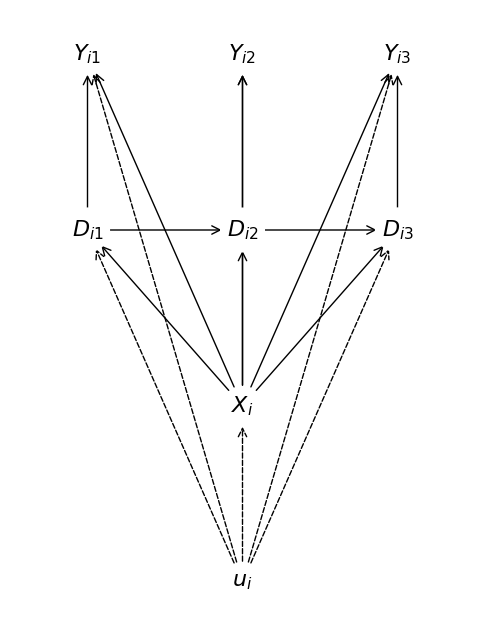

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_causal_graph():
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # 1. Define Positions (x, y)
    pos = {
        'u_i': (2, 0),
        'X_i': (2, 2),
        'D_i1': (1, 4), 'D_i2': (2, 4), 'D_i3': (3, 4),
        'Y_i1': (1, 6), 'Y_i2': (2, 6), 'Y_i3': (3, 6)
    }

    # 2. Helper to draw text
    for name, (x, y) in pos.items():
        # Convert "D_i1" to latex math "$D_{i1}$"
        label = f"${name.replace('_', '_{')}}}$" 
        ax.text(x, y, label, fontsize=16, ha='center', va='center', 
                bbox=dict(boxstyle="circle,pad=0.3", fc="white", ec="none"))

    # 3. Helper to draw arrows
    def draw_arrow(start, end, style='->', ls='-', color='black'):
        x1, y1 = pos[start]
        x2, y2 = pos[end]
        # Shorten start/end so arrow doesn't overlap text
        arrow = patches.FancyArrowPatch((x1, y1), (x2, y2),
                                        arrowstyle=style,
                                        linestyle=ls,
                                        color=color,
                                        mutation_scale=15, # Arrow head size
                                        shrinkA=15, shrinkB=15)
        ax.add_patch(arrow)

    # --- Draw Edges ---
    
    # Time Series D -> D
    draw_arrow('D_i1', 'D_i2')
    draw_arrow('D_i2', 'D_i3')
    
    # D -> Y
    draw_arrow('D_i1', 'Y_i1')
    draw_arrow('D_i2', 'Y_i2')
    draw_arrow('D_i3', 'Y_i3')
    
    # X -> D and Y
    for target in ['D_i1', 'D_i2', 'D_i3', 'Y_i1', 'Y_i2', 'Y_i3']:
        draw_arrow('X_i', target)
        
    # U -> X, D, Y (Dashed)
    draw_arrow('u_i', 'X_i', ls='--')
    draw_arrow('u_i', 'D_i1', ls='--')
    draw_arrow('u_i', 'Y_i1', ls='--')
    draw_arrow('u_i', 'D_i3', ls='--')
    draw_arrow('u_i', 'Y_i3', ls='--')

    # Settings
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(-0.5, 6.5)
    ax.axis('off') # Hide axis box
    plt.show()

draw_causal_graph()

- Conceivably, there could be observed ($X_i$) or unobserved ($u_i$) confounders that affect both the treatment and the outcome $Y_i$, $D_i$ or both.
- But if these are constant over time (so $X_i1 = X_i2$ and $u_i1 = u_i2$), then these are characteristic of the unit that we are observing over time.

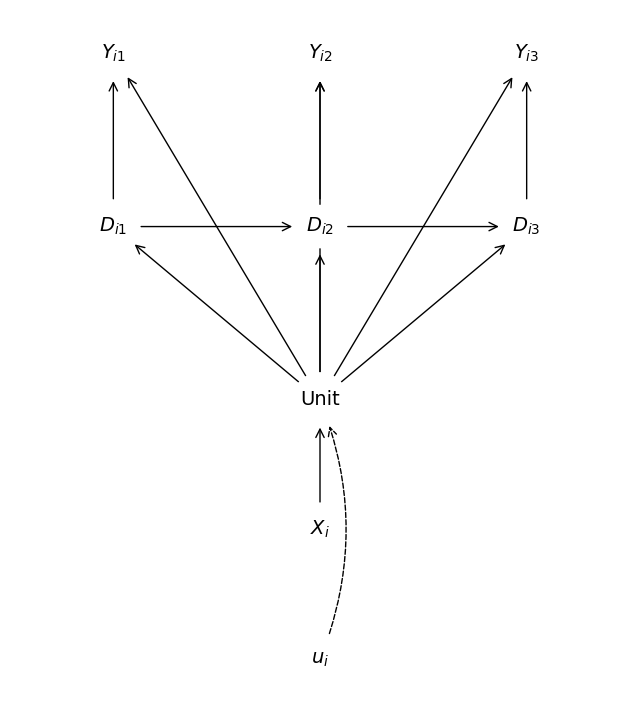

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_causal_graph_with_unit():
    fig, ax = plt.subplots(figsize=(8, 9)) # Slightly taller for the new layer
    
    # 1. Define Positions (x, y)
    # I shifted Y and D up slightly to make room for "Unit"
    pos = {
        'u_i': (2, 0),
        'X_i': (2, 1.5),
        'Unit': (2, 3),   # The new node in the middle
        'D_i1': (1, 5), 'D_i2': (2, 5), 'D_i3': (3, 5),
        'Y_i1': (1, 7), 'Y_i2': (2, 7), 'Y_i3': (3, 7)
    }

    # 2. Draw Nodes
    for name, (x, y) in pos.items():
        # LaTeX formatting
        if name == 'Unit':
            label = "Unit"
        else:
            label = f"${name.replace('_', '_{')}}}$"
            
        # Draw text with a white background box to hide crossing lines
        ax.text(x, y, label, fontsize=14, ha='center', va='center', 
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="none", lw=1))

    # 3. Helper to draw arrows with optional curvature
    def draw_arrow(start, end, style='->', ls='-', color='black', rad=0.0):
        x1, y1 = pos[start]
        x2, y2 = pos[end]
        
        # Connection style handles the curvature (arc3)
        conn_style = f"arc3,rad={rad}"
        
        arrow = patches.FancyArrowPatch((x1, y1), (x2, y2),
                                        arrowstyle=style,
                                        linestyle=ls,
                                        color=color,
                                        connectionstyle=conn_style,
                                        mutation_scale=15,
                                        shrinkA=20, shrinkB=20) # Shrink to not touch text
        ax.add_patch(arrow)

    # --- Draw Edges ---
    
    # 1. Inputs to "Unit"
    # u -> Unit (Dashed because u is unobserved)
    draw_arrow('u_i', 'Unit', ls='--', rad=.2)
    # X -> Unit (Solid)
    draw_arrow('X_i', 'Unit')

    # 2. "Unit" to Everything else
    # We curve the lines to Y so they don't smash through the D nodes
    for target in ['D_i1', 'D_i2', 'D_i3']:
        draw_arrow('Unit', target)
        
    # Curve Y lines: Left curves left, Right curves right, Middle curves slightly
    draw_arrow('Unit', 'Y_i1',)  
    draw_arrow('Unit', 'Y_i2',) # Slight curve to avoid hitting D_i2
    draw_arrow('Unit', 'Y_i3',)

    # 3. Time Series (D -> D)
    draw_arrow('D_i1', 'D_i2')
    draw_arrow('D_i2', 'D_i3')

    # 4. Treatment to Outcome (D -> Y)
    draw_arrow('D_i1', 'Y_i1')
    draw_arrow('D_i2', 'Y_i2')
    draw_arrow('D_i3', 'Y_i3')

    # Settings
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(-0.5, 7.5)
    ax.axis('off')
    plt.show()

draw_causal_graph_with_unit()

## Using OLS with Panel Data

- Suppose we have the following population regression model for unit $i$ at time $t$, where $u_i$ is a time-invariant unobserved confounder:
$$
Y_{it} = \beta_0 + \beta_1 D_{it} + u_{i} + \varepsilon_{it}
$$

- Suppose we ran, with OLS:

$$
Y_{it} = \beta_0 + \beta_1 D_{it} + \eta_{it}
$$

where $\eta_{it} = u_i + \varepsilon_{it}$

- If we just ran OLS (or in this case, called "Pooled OLS"), we would get biased estimates of $\beta_1$ if $X_i$ or $u_i$ are correlated with $D_{it}$. Why?
- The identifying assumption for OLS is that $E[\eta_{it}|D_{it}] = 0$
- But if $u_i$ is correlated with $D_{it}$, then this assumption is violated.

## Fixed Effects (Within Estimator)

- If we observe the same unit over time, we can difference out these time-invariant confounders by looking at changes within the unit over time.
- We can do this by subtracting the average over time for each unit from each observation for that unit.
- This is called the "within estimator" or "fixed effects estimator"
- Since we're taking the average over time for each unit, the time-invariant confounders drop out:
$$
Y_{it} - \bar{Y_i} = \beta_1 (D_{it} - \bar{D_i}) + (u_i - u_i) +(\varepsilon_{it} - \bar{\varepsilon_i})
$$
- This is the basic idea behind panel regression and difference-in-differences.
- We can also add multiple fixed effects (two-way fixed effects) to control for time fixed effects as well.




## Caveats

- Fixed effects cannot address time-variant unobserved heterogeneity
- Even if we were to add fixed effects to time variables, that doesn't solve the problem.
    - if something is changing over time and is correlated with both the treatment and the outcome, we still have bias.
- Now let's see how to implement this in Python.
- We'll use the `pyfixest` library.
- But before that, we need to talk about formulas.

## Formulas

- When estimating linear models, we need an X and y:

$$
y_i = X_i\beta + \varepsilon_i
$$

And for many programs, thats what you need, an `endog` and `exog`, or $y$ and $X$.

But in many instances, you might want to do something more readable, and perhaps you might want to even estimate transformations of variables, or interactions

That's why it's more intuitive and recommended to use R-style formulas in your models.

Most of the libraries we use will use these types of formulas.


## Formulas

- First:

```
pip install pyfixest
pip install rdrobust
pip install wildboottest
pip install moderndid
```

- There of course other packages you can use that implement these things. But these are packages that I have used and think work well
- `rdrobust` is a well-known package that started in R and Stata and has been ported to Python by the authors

## Formulas

- There are two main libraries that other packages use for formulas
    - `patsy` - older but still used by statsmodels 
    - `formulaic` newer and more maintained
    - These are mostly the same for most use-cases, but have some small differences.
- Let's just look at making formulas
    - We'll use `formulaic` (it's already installed as part of `linearmodels`)
    - Note: you don't have to import it separately, `linearmodels` just uses it

In [4]:
from formulaic import Formula
from rdrobust import rdrobust, rdplot
from wildboottest.wildboottest import wildboottest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyfixest as pf
from moderndid import load_mpdta, att_gt, aggte, plot_did
sns.set_theme()

In [5]:
# Let's create some data that we'll use for the rest of the lecture.

# households and time periods
hhids = list(range(1,101))
time_periods = list(range(0,10))
N = len(hhids)
T = len(time_periods)

# choose treated households
rng = np.random.default_rng(seed=1234)

treated = rng.choice(hhids, int(N/2))

# Create fixed effects
alpha_i = {k:v for k,v in zip(hhids, rng.normal(3,2, size=N))}
alpha_t = {k:v for k,v in zip(time_periods, rng.normal(2,1, size=T))}

# create multi-index
multiindex = pd.MultiIndex.from_product([hhids, time_periods], names = ['hhid', 'time'])

# time of treatment
t_star = 5

# effect of controls
gamma = .3

# create variables
df = (
    pd.DataFrame(index = multiindex,
                  columns = ['y'], 
                  data=np.where(multiindex.get_level_values('hhid').isin(treated), 10, 1)
                  )
    .assign(y = lambda df: np.where((df.index.get_level_values('time') >= t_star) \
        & (df.index.get_level_values('hhid').isin(treated)), 
        df['y'] + 10, 
        df['y']),
            treat = lambda df: df.index.get_level_values('hhid').isin(treated).astype(int),
            time_of_treat = lambda df: np.where(df.index.get_level_values('time')>=t_star, 1, 0),
            X = lambda df: rng.normal(100,30, size=N*T),
            alpha_i = lambda df: df.index.get_level_values('hhid').map(alpha_i),
            alpha_t = lambda df: df.index.get_level_values('time').map(alpha_t),
            error_it = rng.normal(0,1, size=N*T))
    .assign(y_did = lambda df: df['y'] + df['X']*gamma + df['alpha_i'] + df['alpha_t'] + df['error_it'],
            y_ols = lambda df: 1 + df['X']*gamma + df['error_it'],
            y_twfe = lambda df: df['X']*gamma + df['alpha_i'] + df['alpha_t'] + df['error_it'],

    )
)

df

y  treat  time_of_treat           X   alpha_i   alpha_t  error_it  \
hhid time                                                                      
1    0     1      0              0   57.096283  0.685178  2.158266  0.082832   
     1     1      0              0   62.379261  0.685178  0.909438  0.190193   
     2     1      0              0  112.179927  0.685178  0.680284 -0.308207   
     3     1      0              0   92.853249  0.685178  2.838651  0.107088   
     4     1      0              0  123.493952  0.685178  4.119764 -0.356980   
...       ..    ...            ...         ...       ...       ...       ...   
100  5     1      0              1   60.216512  3.875725  1.950428 -0.199474   
     6     1      0              1   81.279531  3.875725  2.325698 -0.150037   
     7     1      0              1   89.517010  3.875725  1.451677 -0.516810   
     8     1      0              1   77.633048  3.875725  1.729681  0.389811   
     9     1      0              1  101.491605  3.875725  0.327195  0.012241   

               y_did      y_ols     y_twfe  
hhid time                                   
1    0     21.055161  18.211717  20.055161  
     1     21.498588  19.903971  20.498588  
     2     35.711233  34.345771  34.711233  
     3     32.486893  28.963063  31.486893  
     4     42.496148  37.691206  41.496148  
...              ...        ...        ...  
100  5     24.691632  18.865479  23.691632  
     6     31.435244  25.233822  30.435244  
     7     32.665694  27.338293  31.665694  
     8     30.285131  24.679725  29.285131  
     9     35.662642  31.459722  34.662642  

[1000 rows x 10 columns]

<Axes: xlabel='time', ylabel='y_did'>

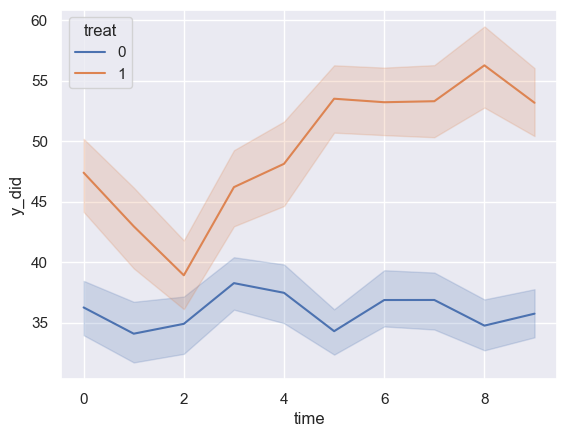

In [6]:
sns.lineplot(x='time', y='y_did', data=df, hue='treat')

In [7]:
"y ~ X + X_controls + W"

'y ~ X + X_controls + W'

In [8]:
f = Formula("y_ols ~ X").get_model_matrix(df)

In [9]:
f.lhs

y_ols
hhid time           
1    0     18.211717
     1     19.903971
     2     34.345771
     3     28.963063
     4     37.691206
...              ...
100  5     18.865479
     6     25.233822
     7     27.338293
     8     24.679725
     9     31.459722

[1000 rows x 1 columns]

In [10]:
f.rhs

Intercept           X
hhid time                       
1    0           1.0   57.096283
     1           1.0   62.379261
     2           1.0  112.179927
     3           1.0   92.853249
     4           1.0  123.493952
...              ...         ...
100  5           1.0   60.216512
     6           1.0   81.279531
     7           1.0   89.517010
     8           1.0   77.633048
     9           1.0  101.491605

[1000 rows x 2 columns]

-  Intercept is automatically included!
- But you can do even more with this
    - Create polynomials
    - apply transformations (using numpy functions)
    - Create dummy variables
    - Create interactions
    - get rid of the intercept

In [11]:

Formula("y_ols ~ -1 + C(treat, Treatment(1)) + np.log(X) + treat*X").get_model_matrix(df).rhs

C(treat, Treatment(1))[0]  C(treat, Treatment(1))[1]  np.log(X)  \
hhid time                                                                    
1    0                             1                          0   4.044739   
     1                             1                          0   4.133233   
     2                             1                          0   4.720104   
     3                             1                          0   4.531020   
     4                             1                          0   4.816192   
...                              ...                        ...        ...   
100  5                             1                          0   4.097947   
     6                             1                          0   4.397894   
     7                             1                          0   4.494429   
     8                             1                          0   4.351993   
     9                             1                          0   4.619976   

           treat           X  treat:X  
hhid time                              
1    0         0   57.096283      0.0  
     1         0   62.379261      0.0  
     2         0  112.179927      0.0  
     3         0   92.853249      0.0  
     4         0  123.493952      0.0  
...          ...         ...      ...  
100  5         0   60.216512      0.0  
     6         0   81.279531      0.0  
     7         0   89.517010      0.0  
     8         0   77.633048      0.0  
     9         0  101.491605      0.0  

[1000 rows x 6 columns]

-  notice when I use the `*` operator, it isn't a multiplication.
- It's actually interaction that adds `treat`, `X` and `treat:X`
    - To just add the interaction, put in `treat:X`


## OLS 

- For regular-degular OLS, we estimate $\beta$ in the equation:

$$
y_i = X_i\beta + \varepsilon_{i}
$$

- To run a regression like this, we use `statsmodels`

In [12]:
mod = pf.feols("y_ols ~ X", data=df)

mod.summary()

###

Estimation:  OLS
Dep. var.: y_ols, Fixed effects: 0
Inference:  iid
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.995 |        0.107 |     9.302 |      0.000 |  0.785 |   1.204 |
| X             |      0.301 |        0.001 |   289.382 |      0.000 |  0.298 |   0.303 |
---
RMSE: 0.99 R2: 0.988 


- This assumes homoskedastic errors, but we can make things a bit more robust using `cov_type`

In [13]:
mod.vcov('hetero').summary()

###

Estimation:  OLS
Dep. var.: y_ols, Fixed effects: 0
Inference:  hetero
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.995 |        0.103 |     9.633 |      0.000 |  0.792 |   1.197 |
| X             |      0.301 |        0.001 |   301.728 |      0.000 |  0.299 |   0.302 |
---
RMSE: 0.99 R2: 0.988 


### Instrumental Variables

- To do instrumental variables, use `IV2SLS` from `linearmodels`
- The formula is a little different but intuitive

In [14]:
mod_iv = pf.feols("y_ols ~ 1 | treat ~ X", data=df)

mod_iv.summary() ### notice that it's an attribute, not a method

###

Estimation:  IV
Dep. var.: y_ols, Fixed effects: 0
Inference:  iid
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |       2.5% |     97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-----------:|----------:|
| Intercept     |  -1258.073 |     7725.798 |    -0.163 |      0.871 | -16418.745 | 13902.598 |
| treat         |   3579.583 |    21460.017 |     0.167 |      0.868 | -38532.350 | 45691.516 |
---



## Fixed Effects

- In this case, we estimate:

$$
y_{it} = X_{it} \beta + \alpha_i + \alpha_t + \varepsilon_{it}
$$

- So there may now be errors that are individual/unit/household specific and also time-specific.


In [15]:
mod_twfe = pf.feols("y_twfe ~ 1 + X", data=df)


mod_twfe.summary() ## Notice that this is an attribute not a method

###

Estimation:  OLS
Dep. var.: y_twfe, Fixed effects: 0
Inference:  iid
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      5.103 |        0.282 |    18.093 |      0.000 |  4.550 |   5.657 |
| X             |      0.301 |        0.003 |   109.813 |      0.000 |  0.295 |   0.306 |
---
RMSE: 2.613 R2: 0.924 


- You can already see that the standard errors are different
- But how do we specify fixed effects?

In [16]:
mod_twfe = pf.feols("y_twfe ~ 1 + X | hhid + time", data=df.reset_index())


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
mod_twfe.summary() # and we recover the original coefficient

###

Estimation:  OLS
Dep. var.: y_twfe, Fixed effects: hhid+time
Inference:  iid
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X             |      0.300 |        0.001 |   270.236 |      0.000 |  0.298 |   0.302 |
---
RMSE: 0.948 R2: 0.99 R2 Within: 0.988 


## Difference-in-Differences Intuition

- Now that we have a handle on panel data and fixed effects, we can use this to understand difference-in-differences.

- Difference-in-Differences is a popular way to estimate a causal effect
- It depends on the assumption of parallel trends:
    - If the treated and untreated groups "evolved" similarly before the onset of treatment (here assumed to happen once and at the same for all treated groups), then you can recover the treatment effect.
- So you don't necessarily need two groups that are identical in every way, just that they would have evolved similarly in the absence of treatment.
- Under parallel trends, which useful quantity does the DiD estimator recover?
    - The Average Treatment Effect on the Treated (ATT) Why?
    - Because the untreated group is only used to construct the counterfactual for the treated group.
    - But you are estimating the effect on the treated group.


## Calculating Difference-in-Differences

![](figures/Gemini_Generated_Image_ynwvl8ynwvl8ynwv.png)

- So what you're doing is, in fact, constructing a counterfactual for the treated group using the untreated group as a proxy for what would have happened in the absence of treatment.


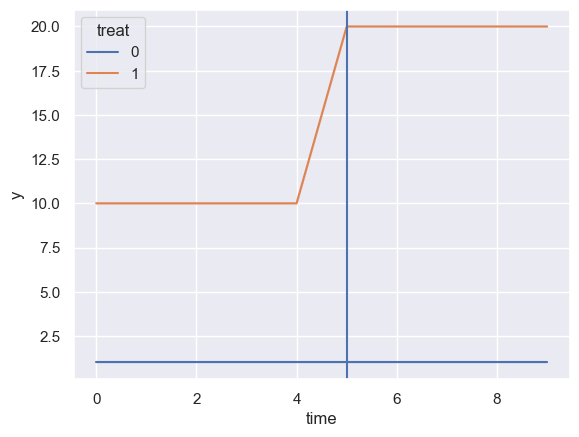

In [18]:
fig, ax  = plt.subplots()

sns.lineplot(x='time', y= 'y', hue='treat', data=df, ax=ax)
ax.axvline(t_star)

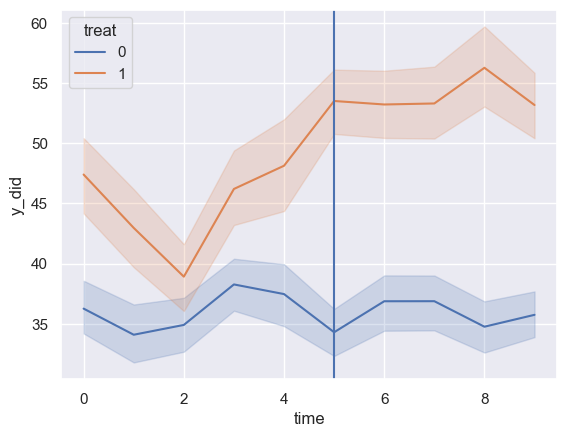

In [19]:
fig, ax  = plt.subplots()

sns.lineplot(x='time', y= 'y_did', hue='treat', data=df, ax=ax)
ax.axvline(t_star)

### Basic 2x2 DiD

- What should the treatment effect be?
- Above, we defined, the variables as:

```
y_1_post = 20
y_1_pre = 10
y_0_post = 1
y_0_pre = 1

(y_1_post - y_0_post) - (y_1_pre - y_0_pre) = (20-1) - (10-1) = 19 - 9 = 10
```


## Estimating the DiD Effect with Regressions

- If we take the same set-up as above, we can estimate the DiD effect using regressions.
- With two time periods and two groups (treated and untreated), we can estimate the following regression:

$$
y = \beta_0 +\beta_1 treat_i + \beta_2 timeAfter_t + \beta_3 treat_i\cdot timeAfter_t  + X'\gamma +  \varepsilon_{it}
$$

and $\beta_3$ will give us the DiD estimate. Why?


- Let's go through it step by step.

- y_0_pre = $E[Y | treat=0, timeAfter=0] = \beta_0$
- y_0_post = $E[Y | treat=0, timeAfter=1] = \beta_0 + \beta_2$
- y_1_pre = $E[Y | treat=1, timeAfter=0] = \beta_0 + \beta_1$
- y_1_post = $E[Y | treat=1, timeAfter=1] = \beta_0 + \beta_1 + \beta_2 + \beta_3$

- So we can write the DiD estimator as:


- (y_1_post - y_0_post) = $(\beta_0 + \beta_1 + \beta_2 + \beta_3) - (\beta_0 + \beta_2) = \beta_1 + \beta_3$
- (y_1_pre - y_0_pre) = $(\beta_0 + \beta_1) - (\beta_0) = \beta_1$


- So the DiD estimator is:
- (y_1_post - y_0_post) - (y_1_pre - y_0_pre) = $(\beta_1 + \beta_3) - (\beta_1) = \beta_3$



In [20]:
# first we need to take out all time before and after

mod_did = pf.feols("y ~ 1 + treat*time_of_treat", data=df.reset_index().query("4 <= time <= 6"))

mod_did.summary()

###

Estimation:  OLS
Dep. var.: y, Fixed effects: 0
Inference:  iid
Observations:  300

| Coefficient         |   Estimate |   Std. Error |               t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------------------:|-----------:|-------:|--------:|
| Intercept           |      1.000 |        0.000 |  9131442354944744.000 |      0.000 |  1.000 |   1.000 |
| treat               |      9.000 |        0.000 | 49309788716701704.000 |      0.000 |  9.000 |   9.000 |
| time_of_treat       |      0.000 |        0.000 |                 9.732 |      0.000 |  0.000 |   0.000 |
| treat:time_of_treat |     10.000 |        0.000 | 44734748770506120.000 |      0.000 | 10.000 |  10.000 |
---
RMSE: 0.0 R2: 1.0 


## Difference-in-Differences with Multiple Time Periods

-  when we have multiple time periods, let's think about how to generalize this by looking at each part of the regression in the 2x2 case:

- `timeAfter` is an indicator for the time period being after treatment
    - But it is now a variable indexing a set of time periods
- `treat` is still an indicator for treatment group
    - But it is time-invariant variable defining the unit
- The interaction `treat*timeAfter` is now an interaction between the treatment group and the time periods after treatment
    - This is still the variable of interest, and will give us the average treatment effect on the treated (ATT) under the parallel trends assumption.
    - This becomes a set of interaction terms, one for each time period after treatment.

- So with multiple time periods,we have:

$$
y_{it} = \beta_1 D_{it} + \alpha_i + \alpha_t + \varepsilon_{it}
$$

- where $\alpha_i$ are unit fixed effects and $\alpha_t$ are time fixed effects.
- And $D_{it}$ is an indicator if unit $i$ is treated at time $t$.
- This is also referred to as a two-way fixed effects model.

## Issues with Two-Way Fixed Effects DiD

- Recent research has shown that the two-way fixed effects DiD estimator can be biased in the presence of treatment effect heterogeneity and staggered adoption of treatment.
- This is because the two-way fixed effects model implicitly weights the treatment effects in a way that can lead to negative weights for some groups, resulting in a biased estimate of the overall treatment effect.
- Let's look at an example with staggered adoption.

### Multiple Units with Differential Timing

- What if there's a staggered roll-out of a program?
- Then treatment groups receiving treatment at different times.


In [22]:
did_m = load_mpdta()

In [23]:
did_m

,year,countyreal,lpop,lemp,first.treat,treat
0,2003,8001,5.896761,8.461469,2007,1
1,2004,8001,5.896761,8.336870,2007,1
2,2005,8001,5.896761,8.340217,2007,1
3,2006,8001,5.896761,8.378161,2007,1
4,2007,8001,5.896761,8.487352,2007,1
...,...,...,...,...,...,...
2495,2003,55137,3.142168,5.955837,2006,1
2496,2004,55137,3.142168,5.924256,2006,1
2497,2005,55137,3.142168,5.942799,2006,1
2498,2006,55137,3.142168,5.937536,2006,1


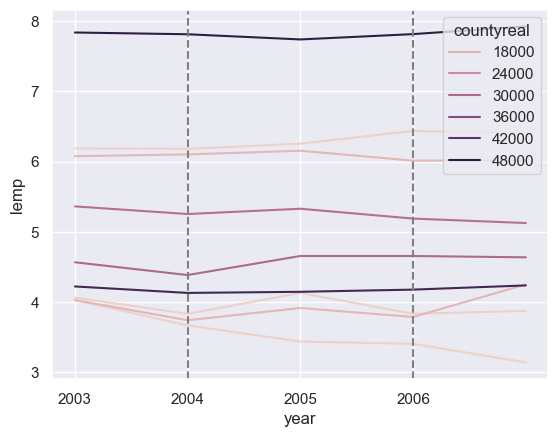

In [26]:
counties = np.random.choice(did_m['countyreal'].unique(), size=10)


fig, ax = plt.subplots()

sns.lineplot(x='year', y = 'lemp', hue='countyreal', data=did_m.query("countyreal in @counties"), ax=ax)
ax.axvline(2006, ls='--', color='gray')
ax.axvline(2004, ls='--', color='gray')
ax.set_xticks(range(2003,2007))


## The Bacon Decomposition 

- The Bacon Decomposition is a way to understand the sources of variation in a difference-in-differences estimator with multiple time periods and staggered treatment timing.
- It decomposes the overall DiD estimate into a weighted average of all possible 2x2 DiD estimates that can be constructed from the data.
- Each 2x2 DiD estimate compares a pair of groups (treatment and control) over a pair of time periods.
- The weights reflect the relative contribution of each 2x2 comparison to the overall DiD estimate.

![](figures/bacon_goodman_1.jpg)
Source: Causal Inference: The Mixtape

## An Example (from CIM)

- Let's say we have three groups: early (k), later (l), and never treated (U).
- Let's say we have 5 periods: the early group gets treated in period 2, the later group gets treated period 4.
- So the early group actually is treated in periods 2, 3, 4, and 5.
- The later group only gets treated for periods 4 and 5.
- How many 2x2 DiD comparisons can we make here?
    - k vs. U
    - l vs. U
    - k vs. l


$$
\begin{aligned}
& \hat{\delta}_{k U}^{2 \times 2}=\left(\bar{y}_k^{\mathrm{post}(k)}-\bar{y}_k^{\mathrm{pre}(k)}\right)-\left(\bar{y}_U^{\mathrm{post}(k)}-\bar{y}_U^{\mathrm{pre}(k)}\right) \\
& \hat{\delta}_{k l}^{2 \times 2}=\left(\bar{y}_k^{\operatorname{mid}(k, l)}-\bar{y}_k^{\mathrm{pre}(k)}\right)-\left(\bar{y}_l^{\operatorname{mid}(k, l)}-\bar{y}_l^{\mathrm{pre}(k)}\right) \\
& \hat{\delta}_{l k}^{2 \times 2}=\left(\bar{y}_l^{\mathrm{post}(l)}-\bar{y}_l^{\operatorname{mid}(k, l)}\right)-\left(\bar{y}_k^{\mathrm{post}(l)}-\bar{y}_k^{\operatorname{mid}(k, l)}\right)
\end{aligned}
$$

- if we were to estimate a two-way fixed effects DiD model on this data, the overall DiD estimate would be a weighted average of these three 2x2 DiD estimates.

$$
\hat{\delta}^{D D}=\sum_{k \neq U} s_{k U} \hat{\delta}_{k U}^{2 \times 2}+\sum_{k \neq U} \sum_{l>k} s_{k l}\left[\mu_{k l} \hat{\delta}_{k l}^{2 \times 2, k}+\left(1-\mu_{k l}\right) \hat{\delta}_{k l}^{2 \times 2, l}\right]
$$

with:

$$
\begin{aligned}
s_{k u} & =\frac{n_k n_u \bar{D}_k\left(1-\bar{D}_k\right)}{\widehat{\operatorname{Var}}\left(\tilde{D}_{i t}\right)} \\
s_{k l} & =\frac{n_k n_l\left(\bar{D}_k-\bar{D}_l\right)\left(1-\left(\bar{D}_k-\bar{D}_l\right)\right)}{\widehat{\operatorname{Var}}\left(\tilde{D}_{i t}\right)} \\
\mu_{k l} & =\frac{1-\bar{D}_k}{1-\left(\bar{D}_k-\bar{D}_l\right)}
\end{aligned}
$$

where $n$ refers to sample sizes, $\bar{D}_k\left(1-\bar{D}_k\right)\left(\bar{D}_k-\bar{D}_l\right)\left(1-\left(\bar{D}_k-\bar{D}_l\right)\right)$ expressions refer to variance of treatment, and the final equation is the same for two timing groups.

## What does this mean?

- Group variation matters, not unit variation
    - The more states that adopted a law at the same time, the bigger they influence that final aggregate estimate itself.
- Being treated in the middle of the panel directly influences the numerical value you get when twoway fixed effects are used to estimate the ATT. 
    - Lengthening or shortening the panel can change the point estimate purely by changing group treatment variance and nothing more.
- If you want to go more in-depth, see [Causal Inference: The Mixtape](https://mixtape.scunning.com/09-difference_in_differences#twoway-fixed-effects-with-differential-timing)

## A Way Around this

- Another set of difference-in-differences estimators have been developed that avoid these issues.
    - And another and another
- Callaway and Sant'Anna (2021) propose a new DiD estimator that is robust to treatment effect heterogeneity and staggered adoption.
- The idea is to estimate group-time average treatment effects (ATT(g,t)) for each group
- Then aggregate these group-time ATTs to get an overall ATT estimate weighted by group sizes.

In [27]:
mod = att_gt(
        data=did_m,
        yname="lemp",
        tname="year",
        gname="first.treat",
        idname="countyreal",
        xformla="~ lpop",
        control_group="nevertreated",
        bstrap=False,
    )

event_study = aggte(mod, type="dynamic")

/Users/lordflaron/Documents/ec34-ds-for-econ/.venv/lib/python3.10/site-packages/moderndid/did/compute_aggte.py:562: UserWarning: Used bootstrap procedure to compute simultaneous confidence band


In [28]:
mod


Reference: Callaway and Sant'Anna (2021)

Group-Time Average Treatment Effects:
  Group   Time   ATT(g,t)   Std. Error  [95% Pointwise Conf. Band]
   2004   2004    -0.0145       0.0221  [ -0.0579,   0.0288]  
   2004   2005    -0.0764       0.0287  [ -0.1326,  -0.0202] *
   2004   2006    -0.1405       0.0354  [ -0.2098,  -0.0711] *
   2004   2007    -0.1069       0.0329  [ -0.1714,  -0.0425] *
   2006   2004    -0.0006       0.0222  [ -0.0441,   0.0429]  
   2006   2005    -0.0063       0.0185  [ -0.0425,   0.0300]  
   2006   2006     0.0009       0.0194  [ -0.0371,   0.0390]  
   2006   2007    -0.0413       0.0197  [ -0.0800,  -0.0027] *
   2007   2004     0.0267       0.0141  [ -0.0009,   0.0543]  
   2007   2005    -0.0046       0.0157  [ -0.0354,   0.0262]  
   2007   2006    -0.0285       0.0182  [ -0.0641,   0.0072]  
   2007   2007    -0.0288       0.0162  [ -0.0606,   0.0030]  
---
Signif. codes: '*' confidence band does not cover 0

P-value for pre-test of parallel trends

## Event Studies

-  Event studies are a way to visualize and estimate the dynamic effects of a treatment over time.
- They are often used in conjunction with difference-in-differences designs to examine how the treatment effect evolves before and after the treatment event.
- The basic idea is to estimate the treatment effect at multiple time points relative to the treatment event.
- This allows us to see not only the immediate effect of the treatment but also how the effect changes over time.
- Event studies can help identify pre-treatment trends and the duration of treatment effects.
- They are typically visualized using plots that show the estimated treatment effects at different time points along with confidence intervals.

$$
Y_{it} = \sum_{k \neq -1} \beta_k \cdot \text{EventTime}_{it}^k + \alpha_i + \alpha_t + \varepsilon_{it}
$$

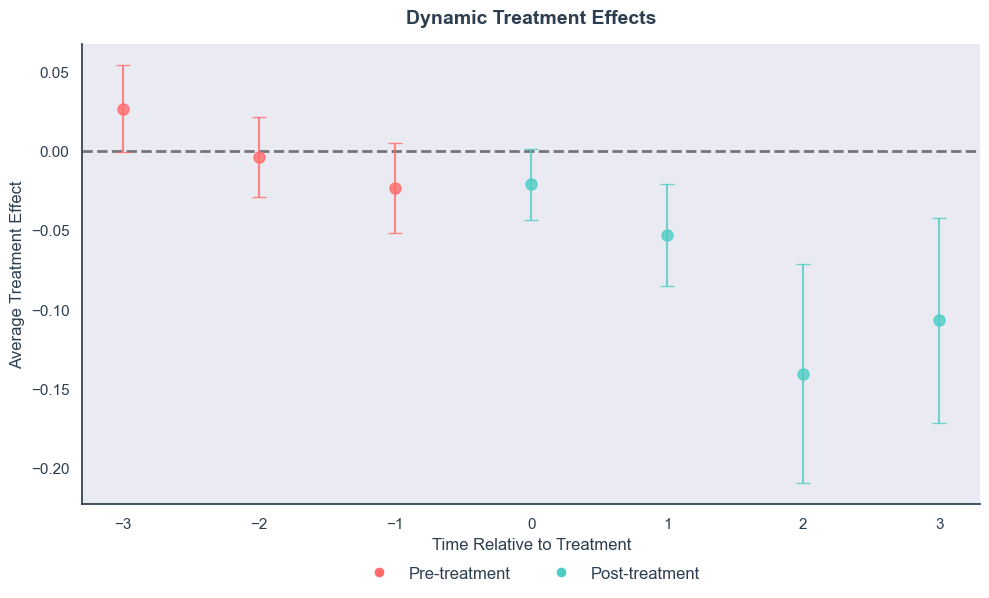

In [32]:
event_study.plot()

## Regression Discontinuity

-  In regression discontinuity, the idea is that units cannot "manipulate" the cutoff
- Imagine students taking tests, and then being admitted into college
    - Student don't know what formula is used or what the "cutoff" for getting into college is
    - So they can't manipulate it and try to "go to the other side"
    - They put in effort to do as best as they can, but those that are just to the left and just to the right, don't know that's where they lie
    - So it would make sense to say then that those students are probably pretty similar to each other
        - and comparing those two groups could be like a natural experiment
- Assuming that's true, though, there's still a problem:
    - how far away from the cutoff do you compare?
    - If you make your "bandwidth" too wide, student are not longer similar to each other; you introduce bias
        - but you get a precise estimate
        - but if you look to narrowly, you won't be biased, but you won't have a lot of observations and high variance
        - bias-variance tradeoff
- We will look at a package that choose "optimal bandwidths" that try to find the sweet spot bandwidth by minimizing some MSE function


### RDRobust

- For this, we will use a dataset of elections from their paper

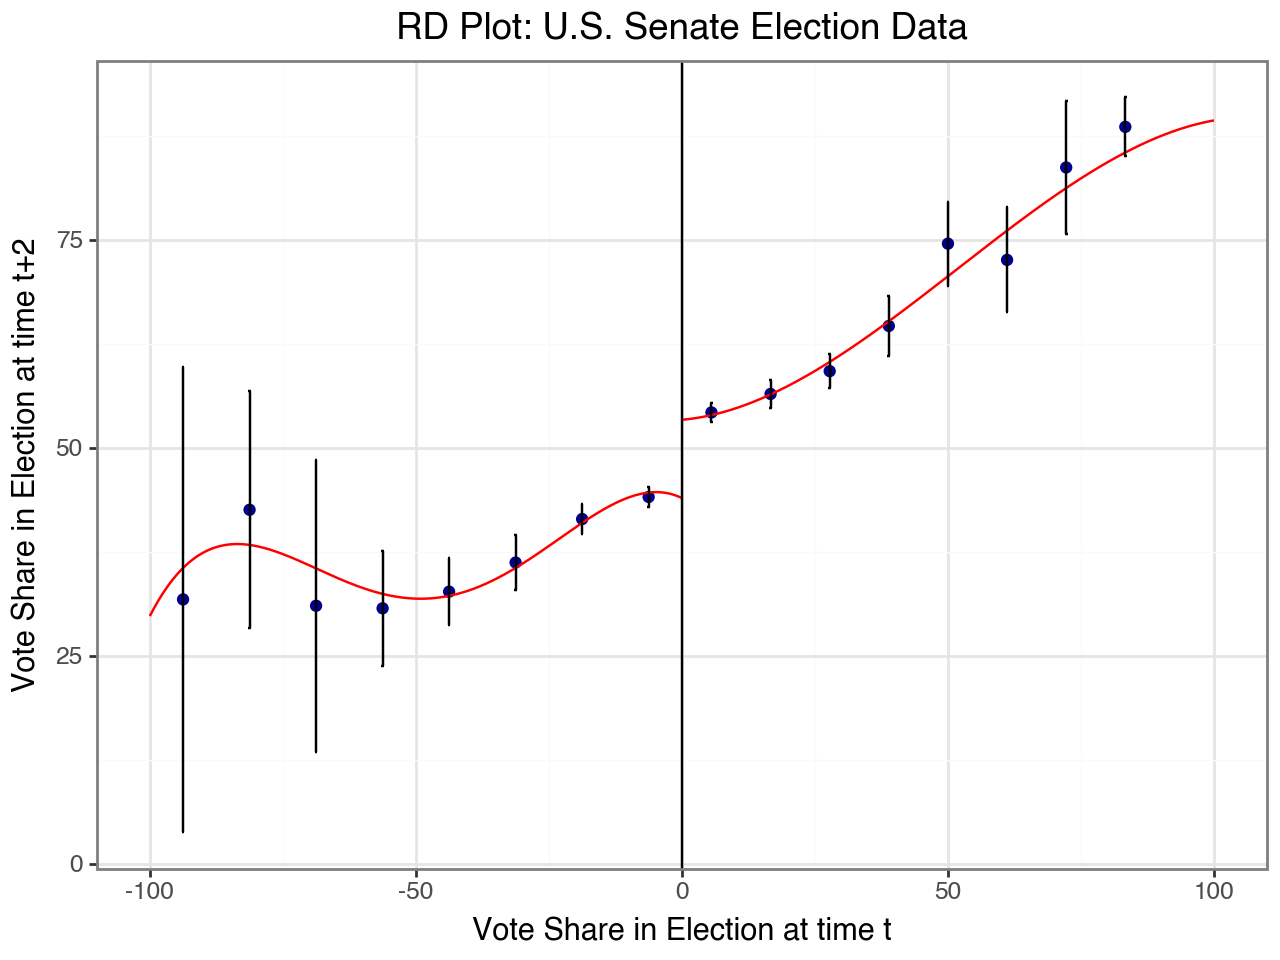

Call: rdplot
Number of Observations:                  1297
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Effective Obs          595        702
Bandwith poly. fit (h)         100.0      100.0
Number of bins scale               1          1
Bins Selected                      8          9
Average Bin Length              12.5     11.111
Median Bin Length               12.5     11.111
IMSE-optimal bins                8.0        9.0
Mimicking Variance bins         15.0       35.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [35]:
voting_data = pd.read_csv("https://raw.githubusercontent.com/rdpackages/rdrobust/master/Python/rdrobust_senate.csv")

margin = voting_data.margin
vote = voting_data.vote

rdplot(y=vote, x=margin, binselect="es", ci=95, 
         title="RD Plot: U.S. Senate Election Data", 
         y_label="Vote Share in Election at time t+2",
         x_label="Vote Share in Election at time t")

In [36]:
res_rdd = rdrobust(y=vote, x=margin, all=True)

In [37]:
print(res_rdd)


Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           595        702
Number of Unique Obs.            595        665
Number of Effective Obs.         360        323
Bandwidth Estimation          17.754     17.754
Bandwidth Bias                28.028     28.028
rho (h/b)                      0.633      0.633

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       7.414    1.459    5.083   3.722e-07    [4.555, 10.273]
Bias-Corrected     7.507    1.459    5.146   2.661e-07    [4.647, 10.366]
Robust             7.507    1

In [38]:
res_rdd.Estimate

,tau.us,tau.bc,se.us,se.rb
Estimate,7.414131,7.506502,1.458716,1.741258
